# Modelling and Evalutation Notebook

### Objectives

- Create a machine learning model
- Train the model
- Tune the model
- Evalutate model on test set
- Save model history

### Inputs

- inputs/brain_tumour_data_set/train (Train set)
- inputs/brain_tumour_data_set/validate (Validation set)
- inputs/brain_tumour_data_set/test (Test set)
- outputs/v1/image_shape.pkl (Image shape embeddings)

### Outputs

- outputs/{version}/brain_tumour.h5 (The model)
- outputs/{version}/evaluation.pkl (The evaluation metrics on the test set)
- outputs/{version}/class_indices.pkl
- outputs/{version}/model_training*.png (plots for training history)

### Install Requirements

In [1]:
%pip install -r /workspace/Brain_tumour_diagnostic/requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Import packages

In [2]:
import os
import joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from keras.models import load_model
import keras_tuner as kt



### Change Working Directory

In [3]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
cwd = os.getcwd()
work_dir =os.getcwd()

### Set Input Directories

In [4]:
my_data_dir = 'inputs/brain_tumour_dataset'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set Output Directories

In [5]:
version = 'v12'

In [6]:
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set Labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['glioma', 'healthy', 'meningioma', 'pituitary']


### Import Image Shape

In [8]:
## Import saved image shape embedding
image_shape = joblib.load(filename=f"outputs/v1/image_shape.pkl")
image_shape

(224, 222, 3)

### Show Number of Images in Datasets

* train - glioma: 1134 images
* train - healthy: 1400 images
* train - meningioma: 1151 images
* train - pituitary: 1229 images
* validation - glioma: 162 images
* validation - healthy: 200 images
* validation - meningioma: 164 images
* validation - pituitary: 175 images
* test - glioma: 325 images
* test - healthy: 400 images
* test - meningioma: 330 images
* test - pituitary: 353 images




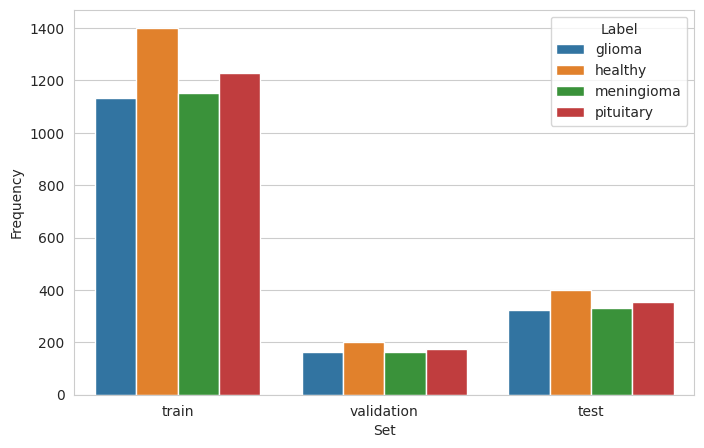

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Augment Image Data

Initialise ImageDataGenerator

In [10]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          #shear_range=0.1,
                                          zoom_range=0.05,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

In [11]:
batch_size = 40  # Set batch size

- Augment train set

In [12]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 4914 images belonging to 4 classes.


{'glioma': 0, 'healthy': 1, 'meningioma': 2, 'pituitary': 3}

- Augment validation set

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 701 images belonging to 4 classes.


{'glioma': 0, 'healthy': 1, 'meningioma': 2, 'pituitary': 3}

- Augment test set

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 1408 images belonging to 4 classes.


{'glioma': 0, 'healthy': 1, 'meningioma': 2, 'pituitary': 3}

### Plot Augmented Images

(40, 224, 222, 3)


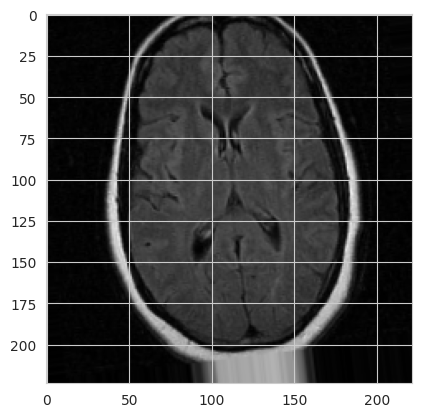

(40, 224, 222, 3)


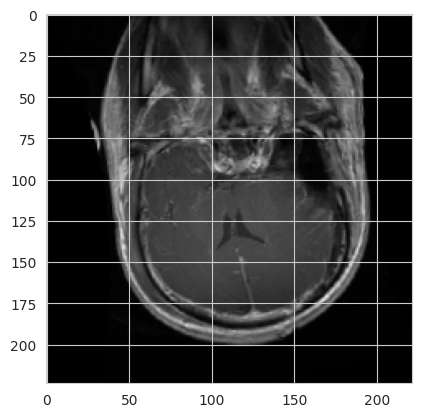

(40, 224, 222, 3)


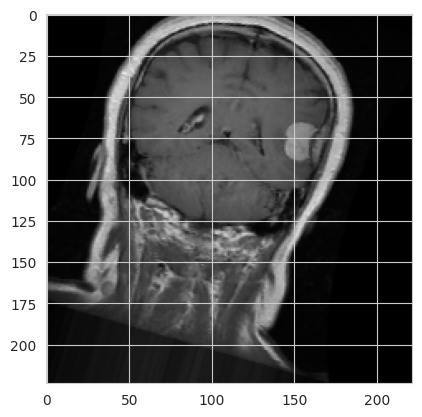

(40, 224, 222, 3)


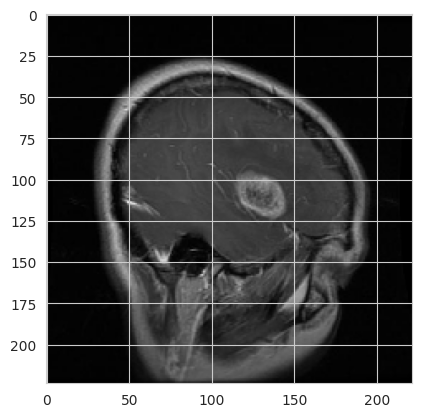

(40, 224, 222, 3)


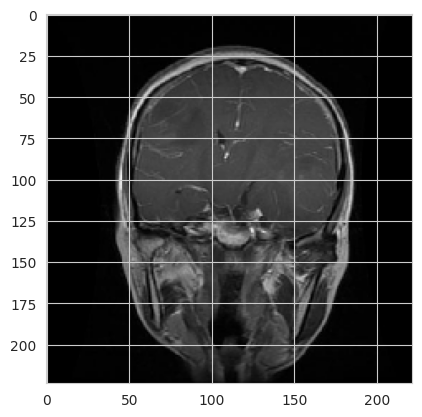

(40, 224, 222, 3)


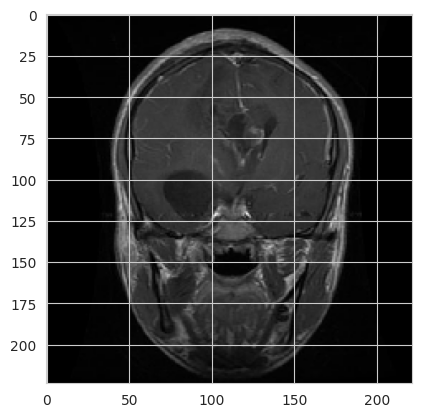

(40, 224, 222, 3)


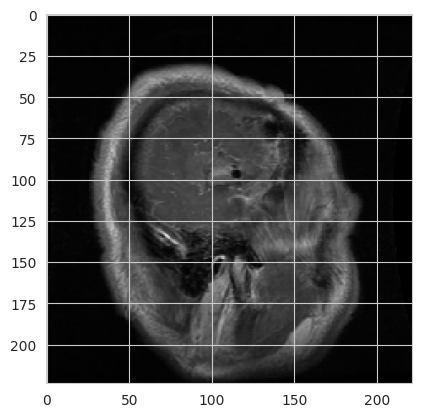

(40, 224, 222, 3)


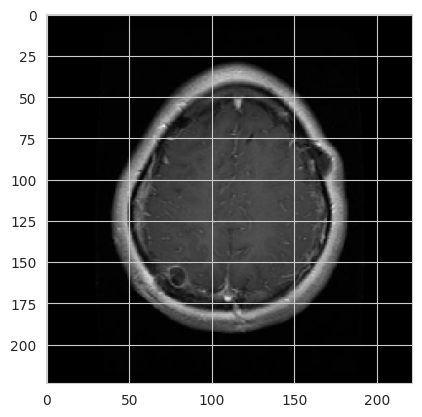

(40, 224, 222, 3)


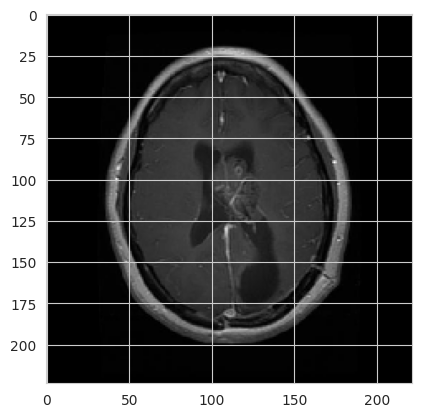

In [15]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [16]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v12/class_indices.pkl']

# Modelling

- Early stopping

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=6)

### Parameter Search

In [ ]:
from tensorflow.keras.metrics import Precision, Recall


def model_builder(hp):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
               activation='relu', ))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
               activation='relu', ))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu'))
    
    model.add(Dropout(0.5))

    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[
                    'categorical_accuracy', 
                    Precision(class_id=0, name='precision_glioma'),
                    Recall(class_id=0, name='recall_glioma'),
                    Precision(class_id=1, name='precision_healthy'),
                    Recall(class_id=1, name='recall_healthy'),
                    Precision(class_id=2, name='precision_meningioma'),
                    Recall(class_id=2, name='recall_meningioma'),
                    Precision(class_id=3, name='precision_pituitary'),
                    Precision(class_id=3, name='recall_pituitary')
                    ]
                    )

    return model

In [ ]:
tuner = tuner = kt.Hyperband(model_builder,
                     objective="val_categorical_accuracy",
                     max_epochs=10,
                     factor=3,
                     )

In [ ]:
tuner.search(train_set,  epochs=50, validation_data=validation_set, callbacks=[early_stop])


Best value: 288

- Meningioma was the worst performing metric, therefore a higher weight is given to improve the performance

In [17]:
class_weight = {
    0: 1.0,
    1: 1.0,
    2: 2.0,
    3: 1.0,
}

### Define Model

In [18]:
from tensorflow.keras.metrics import Precision, Recall


def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
               activation='relu', ))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(288, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[
                    'categorical_accuracy', 
                    Precision(class_id=0, name='precision_glioma'),
                    Recall(class_id=0, name='recall_glioma'),
                    Precision(class_id=1, name='precision_healthy'),
                    Recall(class_id=1, name='recall_healthy'),
                    Precision(class_id=2, name='precision_meningioma'),
                    Recall(class_id=2, name='recall_meningioma'),
                    Precision(class_id=3, name='precision_pituitary'),
                    Precision(class_id=3, name='recall_pituitary')
                    ]
                    )

    return model

- Model Summary

In [19]:
create_tf_model().summary()

2024-10-07 19:13:47.641776: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 220, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 108, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5

- Create model

In [21]:
model = create_tf_model()


- Train Model

In [22]:
model.fit(train_set,
          epochs=50,        
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1,
          
          class_weight=class_weight
          ) 

2024-10-07 19:13:51.845580: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
122/122 [==============================] - 322s 3s/step - loss: 1.4486 - categorical_accuracy: 0.4036 - precision_glioma: 0.0000e+00 - recall_glioma: 0.0000e+00 - precision_healthy: 0.8756 - recall_healthy: 0.4113 - precision_meningioma: 0.4137 - recall_meningioma: 0.1794 - precision_pituitary: 0.4091 - recall_pituitary: 0.4091 - val_loss: 0.9083 - val_categorical_accuracy: 0.5792 - val_precision_glioma: 0.0000e+00 - val_recall_glioma: 0.0000e+00 - val_precision_healthy: 0.9244 - val_recall_healthy: 0.7950 - val_precision_meningioma: 0.4841 - val_recall_meningioma: 0.4634 - val_precision_pituitary: 0.1875 - val_recall_pituitary: 0.1875
Epoch 2/50
122/122 [==============================] - 277s 2s/step - loss: 1.1358 - categorical_accuracy: 0.5577 - precision_glioma: 0.7007 - recall_glioma: 0.0914 - precision_healthy: 0.9138 - recall_healthy: 0.6801 - precision_meningioma: 0.4480 - recall_meningioma: 0.4676 - precision_pituitary: 0.6701 - recall_pituitary: 0.6701 - val_loss: 

- Save Model

In [23]:
model.save(f'outputs/{version}/brain_tumour_model.h5')

- Plot and save training history

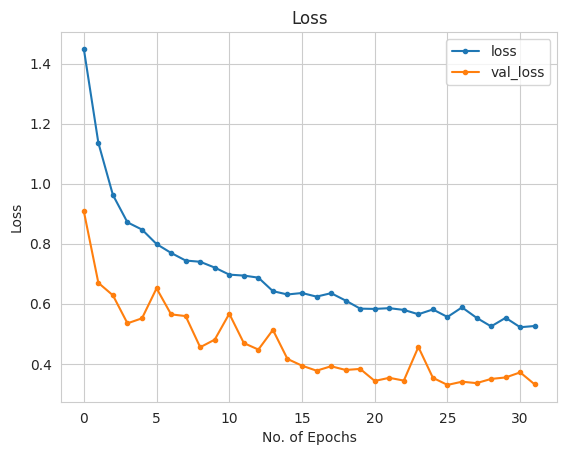

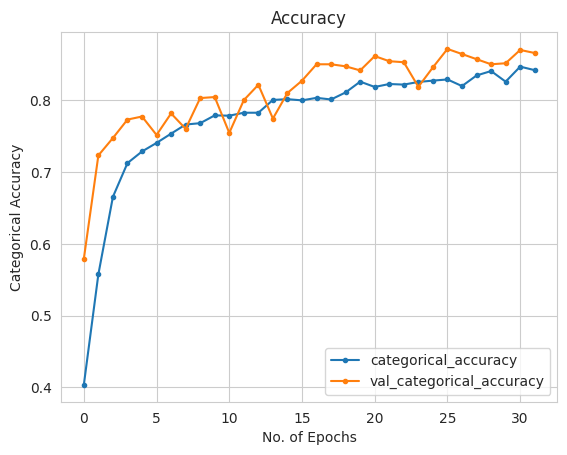

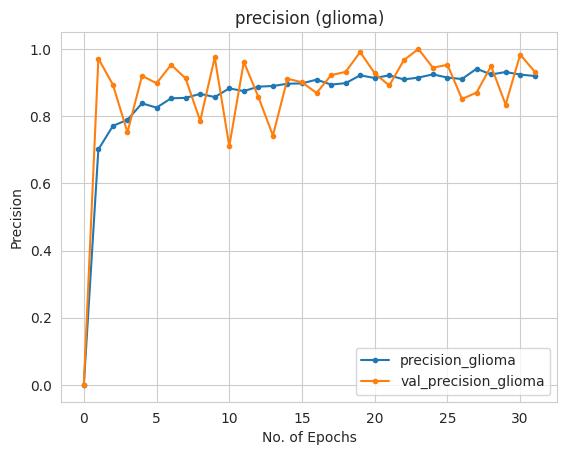

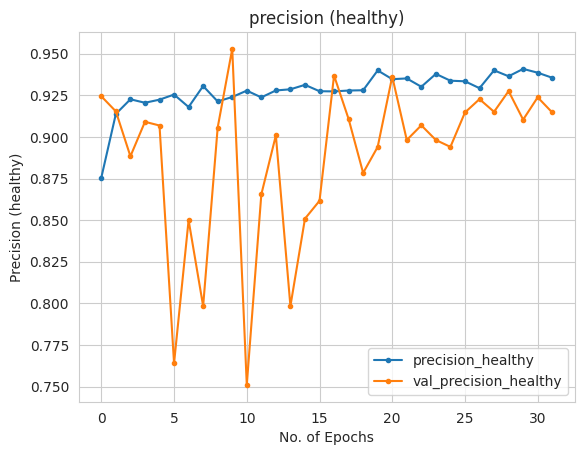

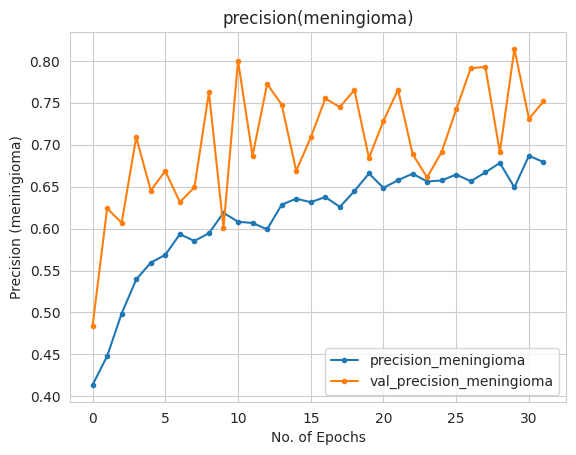

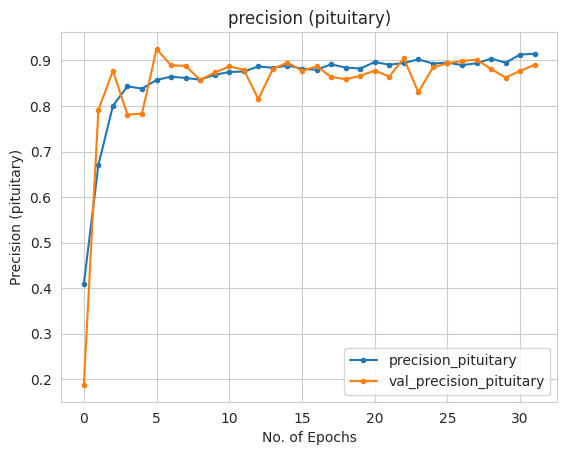

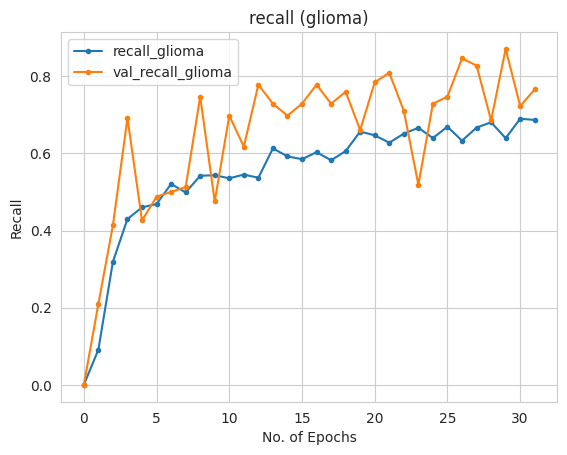

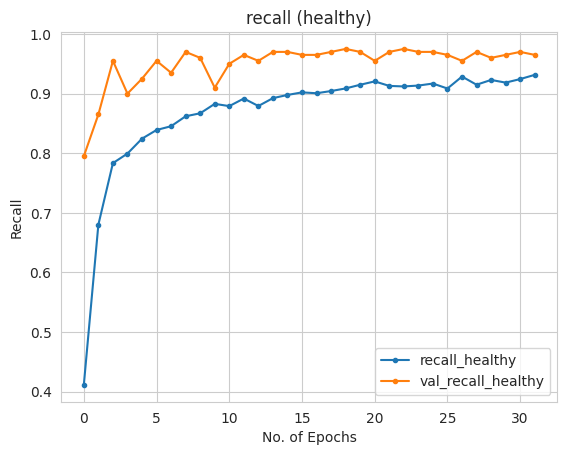

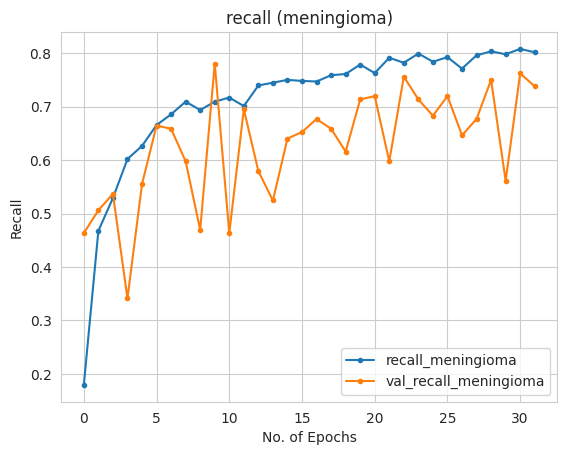

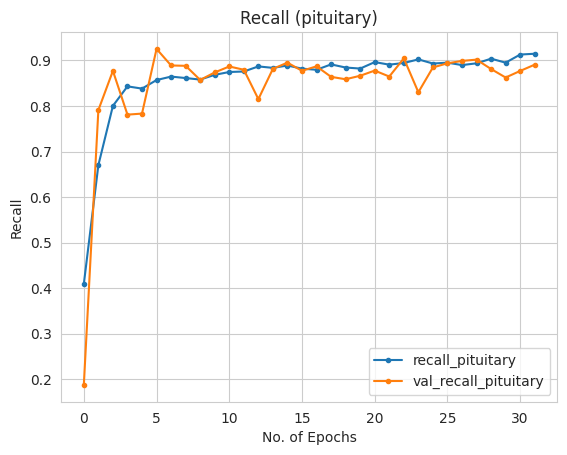

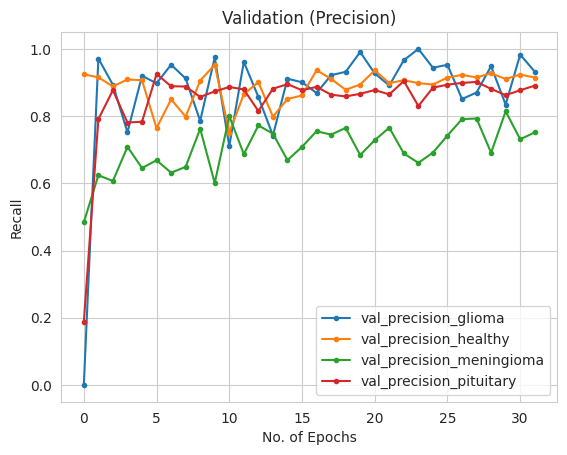

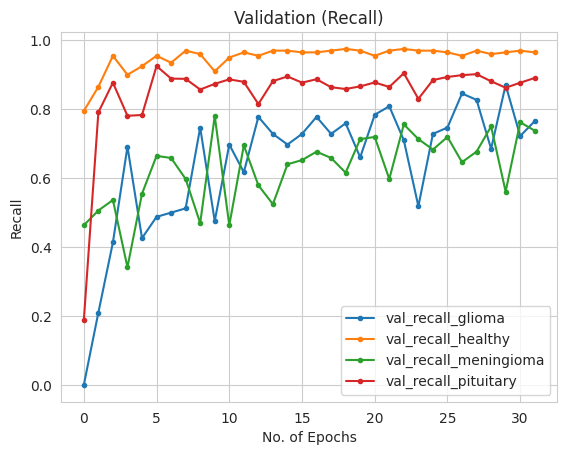

In [24]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.show()

print("\n")
losses[['categorical_accuracy', 'val_categorical_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Accuracy')
plt.show()

print("\n")
losses[['precision_glioma', 'val_precision_glioma']].plot(style='.-')
plt.title("precision (glioma)")
plt.savefig(f'{file_path}/model_training_prec_glioma.png',
            bbox_inches='tight', dpi=150)
plt.xlabel('No. of Epochs')
plt.ylabel('Precision')
plt.show()

print("\n")
losses[['precision_healthy', 'val_precision_healthy']].plot(style='.-')
plt.title("precision (healthy)")
plt.savefig(f'{file_path}/model_training_prec_healthy.png',
            bbox_inches='tight', dpi=150)
plt.xlabel('No. of Epochs')
plt.ylabel('Precision (healthy)')
plt.show()

print("\n")
losses[['precision_meningioma', 'val_precision_meningioma']].plot(style='.-')
plt.title("precision(meningioma)")
plt.savefig(f'{file_path}/model_training_prec_meningioma.png',
            bbox_inches='tight', dpi=150)
plt.xlabel('No. of Epochs')
plt.ylabel('Precision (meningioma)')
plt.show()

print("\n")
losses[['precision_pituitary', 'val_precision_pituitary']].plot(style='.-')
plt.title("precision (pituitary)")
plt.savefig(f'{file_path}/model_training_prec_pituitary.png',
            bbox_inches='tight', dpi=150)
plt.xlabel('No. of Epochs')
plt.ylabel('Precision (pituitary)')
plt.show()

print("\n")
losses[['recall_glioma', 'val_recall_glioma']].plot(style='.-')
plt.title("recall (glioma)")
plt.savefig(f'{file_path}/model_training_rec_glioma.png',
            bbox_inches='tight', dpi=150)
plt.xlabel('No. of Epochs')
plt.ylabel('Recall')
plt.show()

print("\n")
losses[['recall_healthy', 'val_recall_healthy']].plot(style='.-')
plt.title("recall (healthy)")
plt.savefig(f'{file_path}/model_training_rec_healthy.png',
            bbox_inches='tight', dpi=150)
plt.xlabel('No. of Epochs')
plt.ylabel('Recall')
plt.show()

print("\n")
losses[['recall_meningioma', 'val_recall_meningioma']].plot(style='.-')
plt.title("recall (meningioma)")
plt.savefig(f'{file_path}/model_training_rec_meningioma.png',
            bbox_inches='tight', dpi=150)
plt.xlabel('No. of Epochs')
plt.ylabel('Recall')
plt.show()

print("\n")
losses[['recall_pituitary', 'val_recall_pituitary']].plot(style='.-')
plt.title("Recall (pituitary)")
plt.savefig(f'{file_path}/model_training_rec_pituitary.png',
            bbox_inches='tight', dpi=150)
plt.xlabel('No. of Epochs')
plt.ylabel('Recall')
plt.show()

print("\n")
losses[['val_precision_glioma','val_precision_healthy','val_precision_meningioma','val_precision_pituitary']].plot(style='.-')
plt.title("Validation (Precision)")
plt.savefig(f'{file_path}/model_training_prec_all.png',
            bbox_inches='tight', dpi=150)
plt.xlabel('No. of Epochs')
plt.ylabel('Recall')
plt.show()

print("\n")
losses[['val_recall_glioma','val_recall_healthy','val_recall_meningioma','val_recall_pituitary']].plot(style='.-')
plt.title("Validation (Recall)")
plt.savefig(f'{file_path}/model_training_rec_all.png',
            bbox_inches='tight', dpi=150)
plt.xlabel('No. of Epochs')
plt.ylabel('Recall')
plt.show()



- Evaluate model on test set

In [25]:
model = load_model(f'outputs/{version}/brain_tumour_model.h5')
evaluation = model.evaluate(test_set)


36/36 [==============================] - 20s 506ms/step - loss: 0.3317 - categorical_accuracy: 0.8814 - precision_glioma: 0.9358 - recall_glioma: 0.7631 - precision_healthy: 0.9353 - recall_healthy: 0.9750 - precision_meningioma: 0.7683 - recall_meningioma: 0.7939 - precision_pituitary: 0.9183 - recall_pituitary: 0.9183


In [26]:
evaluation

[0.33171606063842773,
 0.8813920617103577,
 0.9358490705490112,
 0.763076901435852,
 0.935251772403717,
 0.9750000238418579,
 0.7683284282684326,
 0.7939394116401672,
 0.9183098673820496,
 0.9183098673820496]

minimum of 0.7 on all metrics for test set achieved

- Save evaluation pickle

In [27]:
print(f"Save file: outputs/{version}/evaluation.pkl")

joblib.dump(value=evaluation,
            filename=f"outputs/{version}/evaluation.pkl")

Save file: outputs/v12/evaluation.pkl


['outputs/v12/evaluation.pkl']

## Conclusions

- After tuning, the model was able to acheive an accuracy and precison of 0.7 or greater on all labels

## Next Steps

- Use the model to make predictions on unseen data